# Prep

## Dependencies

In [1]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-25 21:12:02.875781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 21:12:08.764433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-25 21:12:08.764628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Constants

In [2]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 100
VALID_SPLIT = 0.1 # 10% of the TEST dataset so 8% overall
TEST_SPLIT = 0.2
LABEL_COLUMN = 'label'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 41
LEARNING_RATE = 1e-4
MODEL_PREFIX = "DarkNet"
OUT_MODEL_PATH = f"./{MODEL_PREFIX}-models"

## Prepare Datasets

In [3]:
# Get paths
d1_data_path = path.join(os.getcwd(), "data/d1")

d2_data_path = path.join(os.getcwd(), "data/d2")

In [4]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
def split_into_train_valid_test(df, test_split=TEST_SPLIT, valid_split=VALID_SPLIT):
    # Stratify split test dataset into test and validation
    full_train_df, test_df = train_test_split(df,
                                         test_size=test_split,
                                         shuffle=True,
                                         stratify=df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )

    train_df, valid_df = train_test_split(full_train_df,
                                         test_size=valid_split,
                                         shuffle=True,
                                         stratify=full_train_df[LABEL_COLUMN],
                                         random_state=RANDOM_STATE
                                        )
    return train_df, valid_df, test_df

In [5]:
df_1 = get_image_df(d1_data_path)
df_2 = get_image_df(d2_data_path)
display(df_1.sample(5).head())
display(df_2.sample(5).head())

,image_path,label
299,covid/COVID-2472.png,covid
419,covid/COVID-2784.png,covid
2732,normal/NORMAL-3540.png,normal
241,covid/COVID-1776.png,covid
302,covid/COVID-1383.png,covid


,image_path,label
769,covid/COVID-975.png,covid
1370,normal/NORMAL-8928.png,normal
1641,normal/NORMAL-9333.png,normal
1664,normal/NORMAL-9375.png,normal
766,covid/COVID-321.png,covid


In [6]:
train_df_1, valid_df_1, test_df_1 = split_into_train_valid_test(df_1)
train_df_2, valid_df_2, test_df_2 = split_into_train_valid_test(df_2)

## Load Dataset

In [7]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   # featurewise_center = True,
                                   # featurewise_std_normalization = True,
                                   # width_shift_range=0.2,
                                   # height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   # zca_whitening = True,
                                   # channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   # vertical_flip = True ,
                                   # validation_split = 0.2,
                                   fill_mode='constant')



flow_kwargs = {
    # 'directory': train_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_batches_1 = train_datagen.flow_from_dataframe(dataframe=train_df_1,
                                                  directory=d1_data_path, shuffle=True, **flow_kwargs)

valid_batches_1 = train_datagen.flow_from_dataframe(dataframe=valid_df_1,
                                                  directory=d1_data_path, shuffle=False, **flow_kwargs)

test_batches_1 = test_datagen.flow_from_dataframe(dataframe=test_df_1,
                                                directory=d1_data_path, shuffle=False, **flow_kwargs)

train_batches_2 = train_datagen.flow_from_dataframe(dataframe=train_df_2,
                                                  directory=d2_data_path, shuffle=True, **flow_kwargs)

valid_batches_2 = train_datagen.flow_from_dataframe(dataframe=valid_df_2,
                                                  directory=d2_data_path, shuffle=False, **flow_kwargs)

test_batches_2 = test_datagen.flow_from_dataframe(dataframe=test_df_2,
                                                directory=d2_data_path, shuffle=False, **flow_kwargs)

DATASETS_1 = {
    'train_1': train_batches_1,
    "validation_1": valid_batches_1,
    'test_1': test_batches_1,
}

DATASETS_2 = {
    'train_2': train_batches_2,
    "validation_2": valid_batches_2,
    'test_2': test_batches_2,
}

DATASETS = {
    **DATASETS_1,
    **DATASETS_2
}

Found 3562 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 1644 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 457 validated image filenames belonging to 2 classes.


# EDA

In [8]:
print(train_batches_1.class_indices)

{'normal': 0, 'covid': 1}


In [9]:
print(f"Train dataset 1 length: {len(train_df_1)}")
print(f"Valid dataset 1 length: {len(valid_df_1)}")
print(f"Test dataset 1 length: {len(test_df_1)}")

Train dataset 1 length: 3562
Valid dataset 1 length: 396
Test dataset 1 length: 990


In [10]:

print(f"Train dataset 2 length: {len(train_df_2)}")
print(f"Valid dataset 2 length: {len(valid_df_2)}")
print(f"Test dataset 2 length: {len(test_df_2)}")

Train dataset 2 length: 1644
Valid dataset 2 length: 183
Test dataset 2 length: 457


In [11]:
xb, yb = train_batches_1.next()
xb.shape,yb.shape

((32, 224, 224, 3), (32, 2))

In [12]:
xb, yb = train_batches_2.next()
xb.shape,yb.shape

((32, 224, 224, 3), (32, 2))

In [13]:
def display_class_sample(df, data_path, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

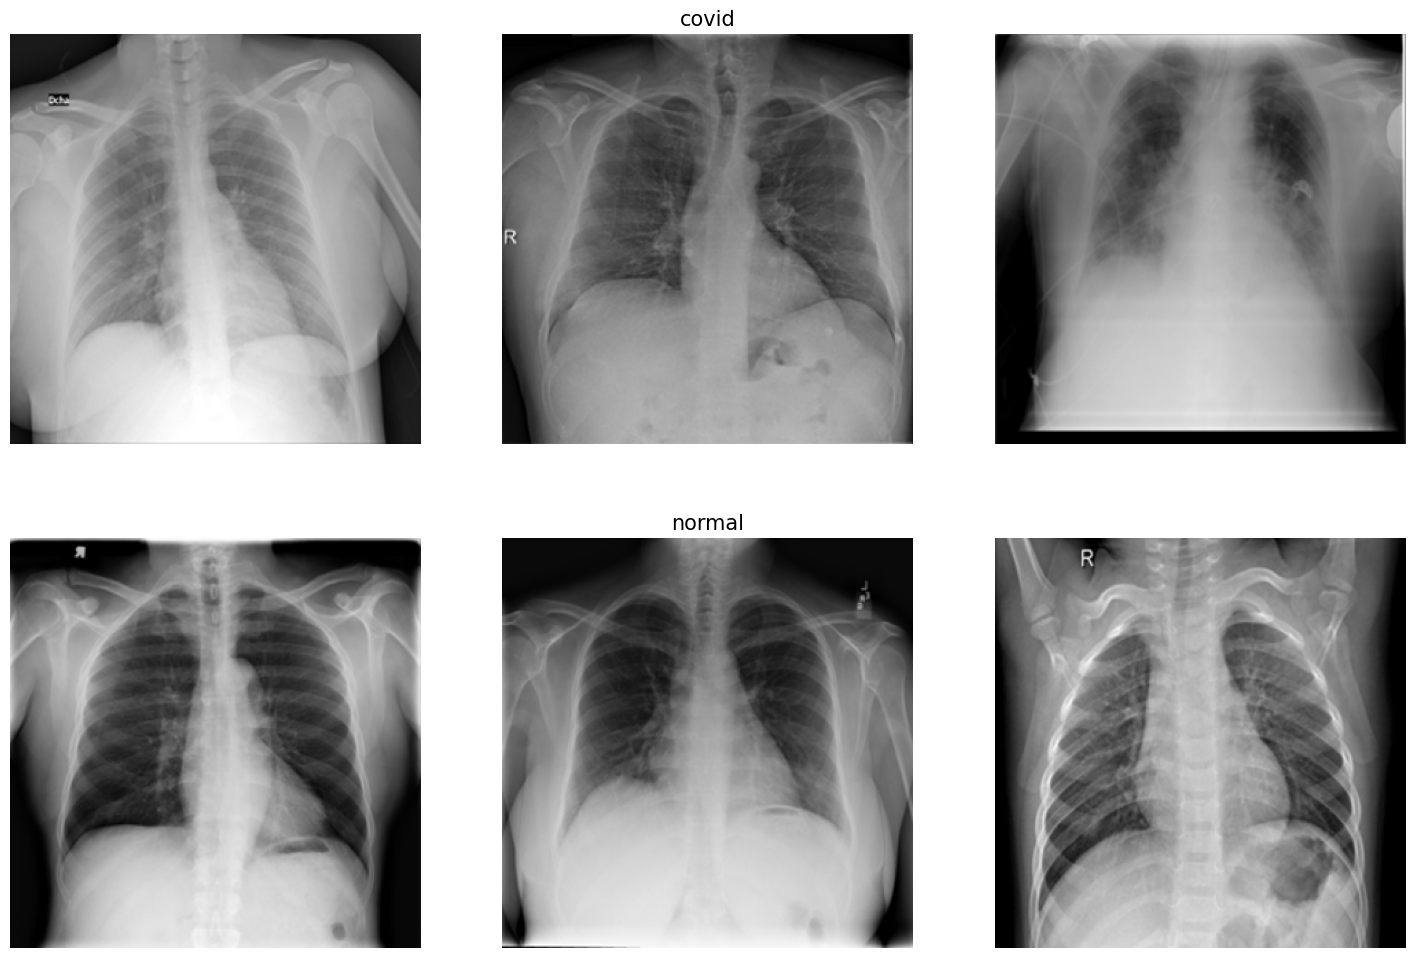

In [14]:
display_class_sample(train_df_1, d1_data_path)

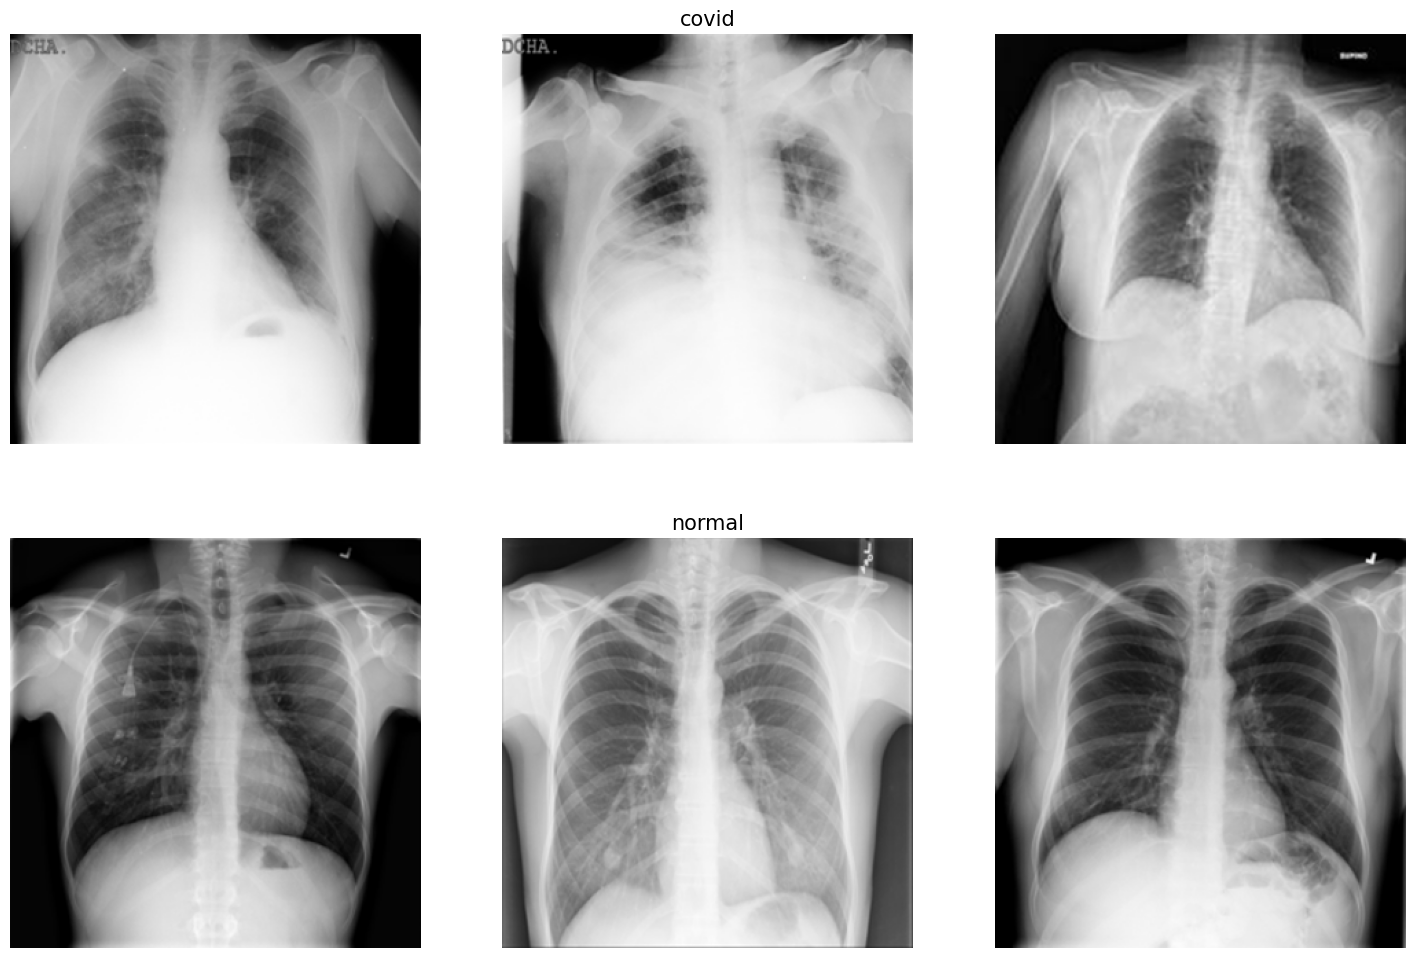

In [15]:
display_class_sample(train_df_2, d2_data_path)

# Train Model

## Build CovidDarkNet

In [16]:
def conv_block(num_filters, kernel_size=3, stride=1, padding="same", **kwargs):
    strides = (stride, stride) # Assuming symmetric stride
    return [
        layers.Conv2D(filters=num_filters,
                      kernel_size=kernel_size,
                      strides=strides,
                      padding=padding,
                     use_bias=False, **kwargs),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1)] # Matching torchvision

In [17]:
def triple_conv(num_filters_outer, num_filters_inner, name="triple"):
    return [
        *conv_block(num_filters_outer, name=f"{name}_start"),
        *conv_block(num_filters_inner, kernel_size=1, padding="same"),
        *conv_block(num_filters_outer, name=f"{name}_end")]

In [18]:
def maxpooling():
    return layers.MaxPool2D((2,2))

In [19]:
def build_model(summary=True):
    model = keras.Sequential([
        layers.Input(shape=(*IMAGE_SIZE, 3)),

        # Conv block 1
        *conv_block(8),
        maxpooling(),

        # Conv block 2
        *conv_block(16),
        maxpooling(),

        # Triple conv 1
        *triple_conv(32, 16, name="triple_1"),
        maxpooling(),

        # Triple conv 2
        *triple_conv(64, 32, name="triple_2"),
        maxpooling(),

        # Triple conv 3
        *triple_conv(128, 64, name="triple_3"),
        maxpooling(),

        # Triple conv 4
        *triple_conv(256, 128, name="triple_4"),

        # Conv block 3
        *conv_block(128, kernel_size=1),

        # Conv block 4
        *conv_block(256),

        # Conv layer 1
        layers.Conv2D(filters=2, kernel_size=3, strides=(1,1), padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),

        # Dense
        layers.Flatten(),
        layers.Dense(2, activation=None)
        ]
    )

    model.build()

    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
           metrics = ['accuracy'], steps_per_execution=1)
    if summary:
        print(model.summary())
        
    return model

In [20]:
model_1 = build_model(summary=False)
model_2 = build_model(summary=False)

2023-04-25 21:12:17.734273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-25 21:12:17.734368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive): /proc/driver/nvidia/version does not exist
2023-04-25 21:12:17.735287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit Model

In [21]:
def train_model_and_save_results(model, *args, name=None, out_path=OUT_MODEL_PATH, out_time=None, save_final=True, **kwargs):
    if not name:
        raise Exception("Must supply name when training multiple models")
        
    if not out_time:
        out_time = datetime.now()
    out_path = path.join(out_path, out_time.strftime("%Y-%m-%dT%H:%M"))
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+ name + "-{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    history_logger = tf.keras.callbacks.CSVLogger(path.join(out_path, name+"-train-log.csv"), separator=",", append=False)
    
    callbacks=kwargs.pop("callbacks", [])
    callbacks.append(save_model)
    callbacks.append(history_logger)

    history = model.fit(callbacks=callbacks, *args, **kwargs)
    np.save(path.join(out_path, name+"-history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + name +"-last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

def load_model(model, model_path, checkpoint_name, history_name="history.npy"):
    model_path = path.join(OUT_MODEL_PATH, model_path)
    checkpoint_path = path.join(model_path, checkpoint_name)
    history_path = path.join(model_path, history_name)
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history
    
def train_together():
    """
    Only used to synchronize clocks for output models into the same folder
    """
    out_time = datetime.now()
    
    # callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, 
    #                        mode='min', restore_best_weights=True)]

    try:
        history_1 = train_model_and_save_results(model_1, train_batches_1,
                                 name=f"{MODEL_PREFIX}-1",
                                 out_time=out_time,
                                 validation_data=valid_batches_2,
                                 epochs=NUM_EPOCHS,
                                 workers=1,
                                 # callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_1: {e}")
        
    try:
        history_2 = train_model_and_save_results(model_2, train_batches_2,
                             name=f"{MODEL_PREFIX}-2",
                             out_time=out_time,
                             validation_data=valid_batches_2,
                             epochs=NUM_EPOCHS,
                             workers=1,
                             # callbacks=callbacks
                            )
    except Exception as e:
        print(f"Failed to train model_2: {e}")
    
    return history_1, history_2

In [54]:
LOAD_MODEL_1 = False

if LOAD_MODEL_1:
    # history_1 = load_model(model_1, history_name=f"{MODEL_PREFIX}-1-history.npy", xx, xx)
    pass
else:    
    history_1 = train_model_and_save_results(model_1, train_batches_1,
                                 name=f"{MODEL_PREFIX}-1",
                                 out_time=datetime.now(),
                                 validation_data=valid_batches_1,
                                 epochs=NUM_EPOCHS,
                                 workers=1,)
                                 # class_weight=class_weights)

KeyboardInterrupt: 

In [ ]:
# LOAD_MODEL_2 = False

if LOAD_MODEL_2:
    # history_2 = load_model(model_1, history_name=f"{MODEL_PREFIX}-2-history.npy", xx, xx)
    pass
else:
    history_2 = train_model_and_save_results(model_2, train_batches_2,
                                 name=f"{MODEL_PREFIX}-2",
                                 out_time=datetime.now(),
                                 validation_data=valid_batches_2,
                                 epochs=NUM_EPOCHS,                                             
                                 workers=1,)
                                 # class_weight=class_weights)

In [22]:
history_1, history_2 = train_together()

Epoch 1/100
112/112 [==============================] - 104s 880ms/step - loss: 0.5443 - accuracy: 0.7310 - val_loss: 0.7904 - val_accuracy: 0.4973
Epoch 2/100
112/112 [==============================] - 105s 932ms/step - loss: 0.3836 - accuracy: 0.8259 - val_loss: 0.8882 - val_accuracy: 0.4973
Epoch 3/100
112/112 [==============================] - 104s 927ms/step - loss: 0.3162 - accuracy: 0.8582 - val_loss: 0.6643 - val_accuracy: 0.6503
Epoch 4/100
112/112 [==============================] - 97s 860ms/step - loss: 0.2806 - accuracy: 0.8857 - val_loss: 0.6147 - val_accuracy: 0.7049
Epoch 5/100
112/112 [==============================] - 105s 936ms/step - loss: 0.2522 - accuracy: 0.8933 - val_loss: 0.3922 - val_accuracy: 0.8306
Epoch 6/100
112/112 [==============================] - 104s 929ms/step - loss: 0.2294 - accuracy: 0.9040 - val_loss: 0.4020 - val_accuracy: 0.8415
Epoch 7/100
112/112 [==============================] - 96s 851ms/step - loss: 0.2134 - accuracy: 0.9107 - val_loss: 0.3

# Evaluate

In [23]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    
    batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    
    for idx in tqdm(range(len(batches))):
        img_batch, y_batch = batches[idx]
        
        preds_batch = model.predict(img_batch, verbose=0)
        
        if single_binary_neuron:
            # For single neuron with binary class probabily output
            y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
        else:
            # For multi class or binary class using 2 neurons
            y_pred_batch = np.argmax(preds_batch, axis=-1)
            
        y_true_batch = np.argmax(y_batch,-1)
        
        
        y_pred_batches.append(y_pred_batch)
        y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)
    
    return y_pred, y_true

def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True):
    y_pred, y_true = get_pred_and_truth(model, dataset)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'val'], loc='upper left')
    plt.show()

## Model 1 (Trained on Dataset 1)

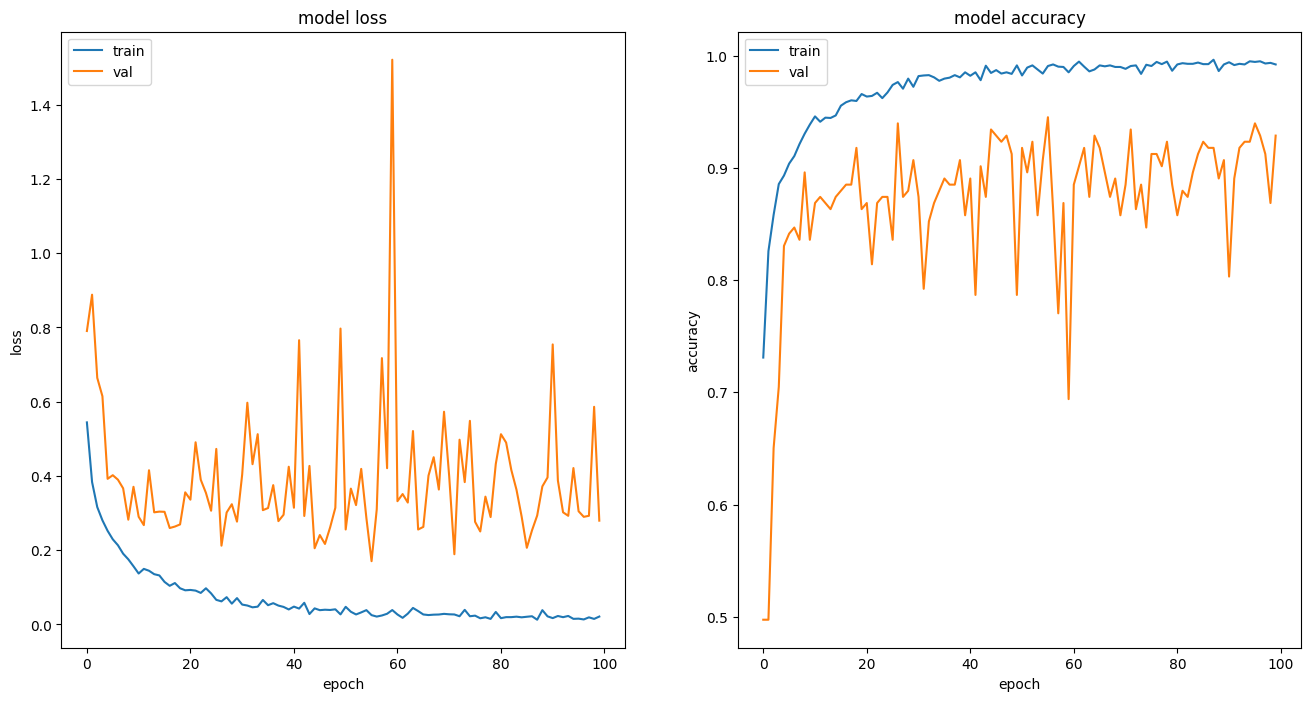

In [24]:
plot_loss_accuracy_curves(history_1, plot=True)

  0%|          | 0/112 [00:00<?, ?it/s]


----------------------------- Classification report for train_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.994947
1,Recall,0.997754
2,Specificity,0.992139
3,Precision,0.992183
4,F1 Score,0.994961


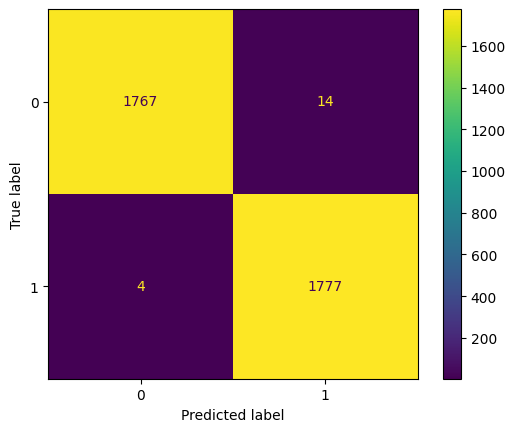

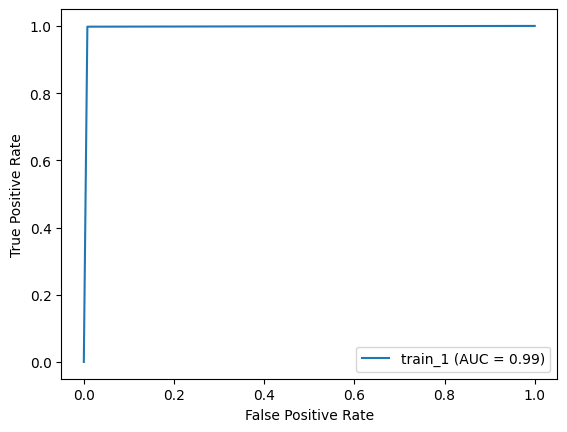

  0%|          | 0/13 [00:00<?, ?it/s]


----------------------------- Classification report for validation_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.952020
1,Recall,0.979798
2,Specificity,0.924242
3,Precision,0.928230
4,F1 Score,0.953317


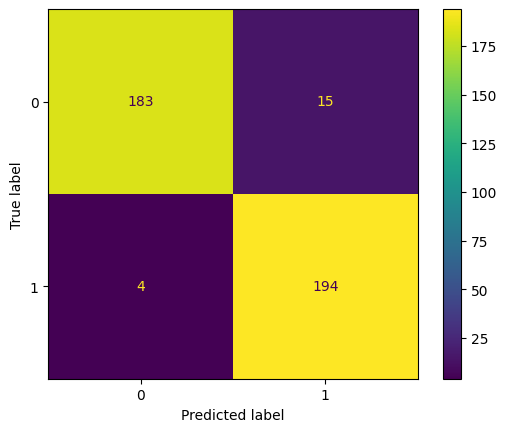

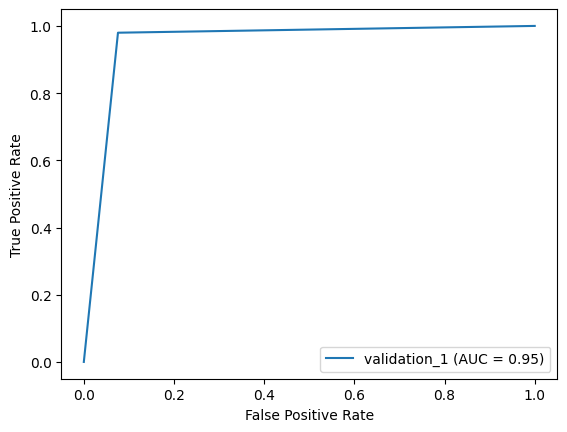

  0%|          | 0/31 [00:00<?, ?it/s]


----------------------------- Classification report for test_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.970707
1,Recall,0.961616
2,Specificity,0.979798
3,Precision,0.979424
4,F1 Score,0.970438


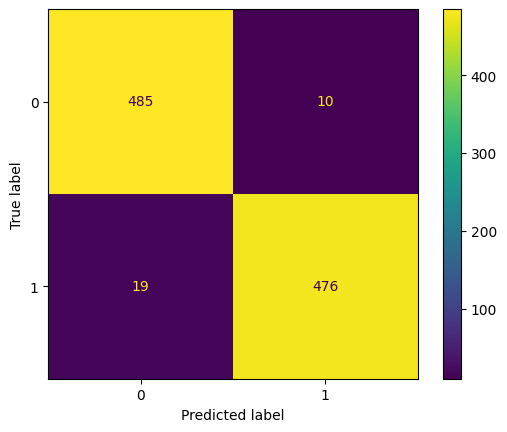

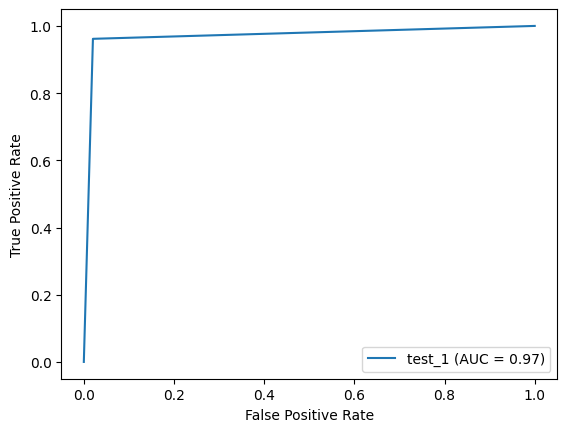

In [26]:
evaluate_on_all_datasets(model_1, datasets=DATASETS_1)

  0%|          | 0/52 [00:00<?, ?it/s]


----------------------------- Classification report for train_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.938564
1,Recall,0.948905
2,Specificity,0.928224
3,Precision,0.929678
4,F1 Score,0.939193


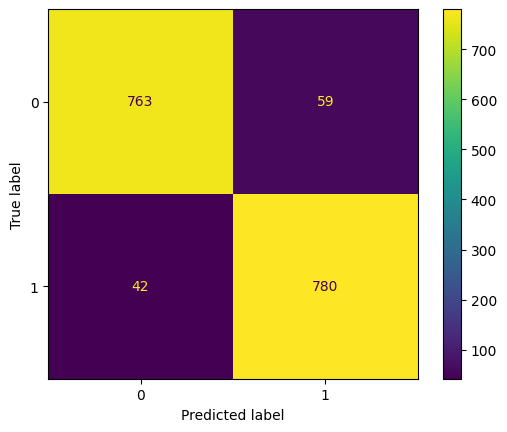

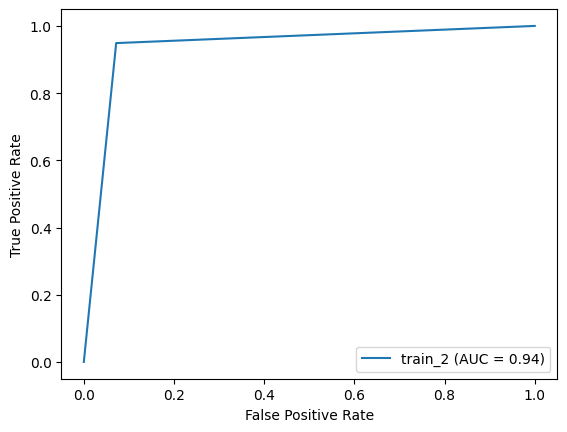

  0%|          | 0/6 [00:00<?, ?it/s]


----------------------------- Classification report for validation_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.945355
1,Recall,0.945055
2,Specificity,0.945652
3,Precision,0.945055
4,F1 Score,0.945055


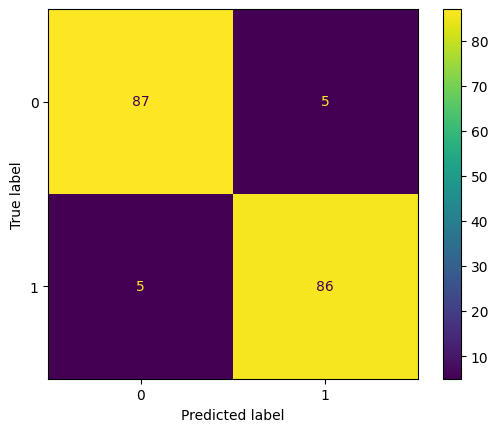

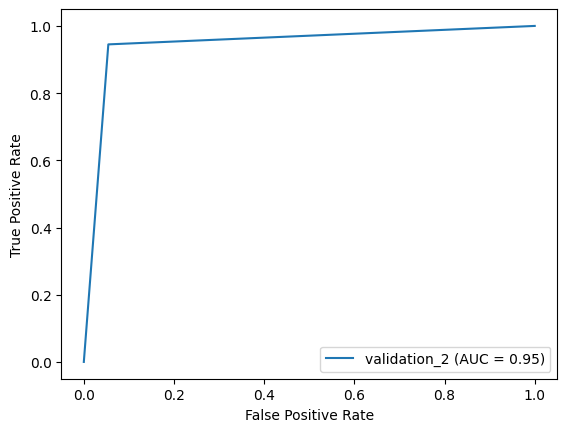

  0%|          | 0/15 [00:00<?, ?it/s]


----------------------------- Classification report for test_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.945295
1,Recall,0.917031
2,Specificity,0.973684
3,Precision,0.972222
4,F1 Score,0.943820


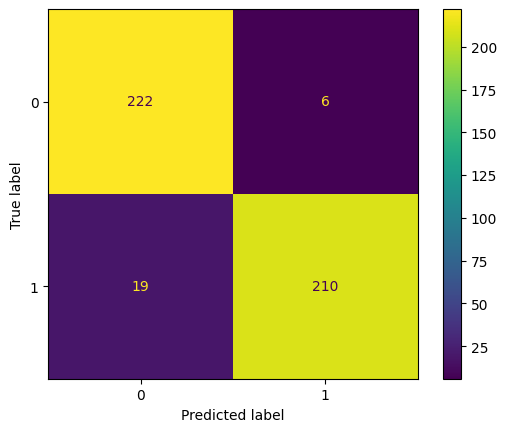

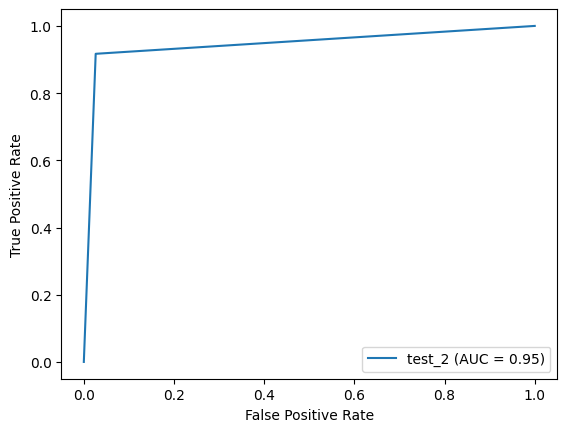

In [27]:
evaluate_on_all_datasets(model_1, datasets=DATASETS_2)

## Model 2 (Trained on Dataset 2)

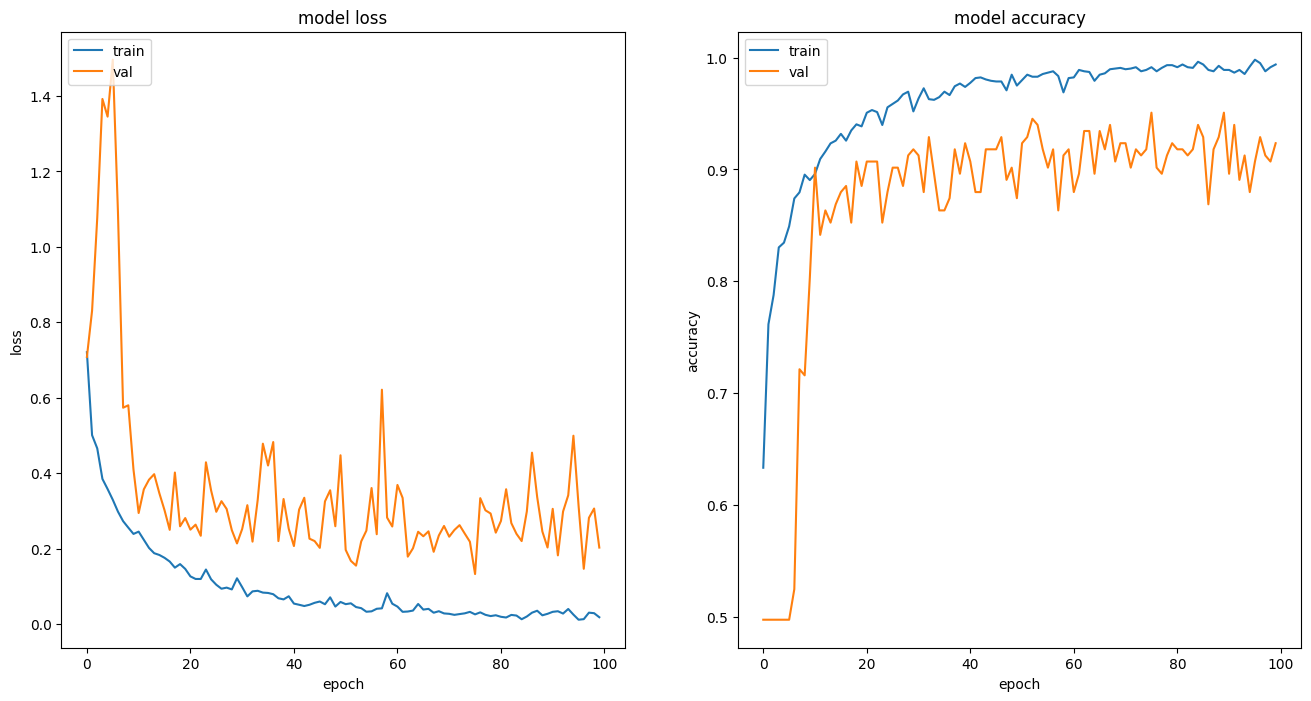

In [28]:
plot_loss_accuracy_curves(history_2, plot=True)

  0%|          | 0/52 [00:00<?, ?it/s]


----------------------------- Classification report for train_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.992701
1,Recall,0.997567
2,Specificity,0.987835
3,Precision,0.987952
4,F1 Score,0.992736


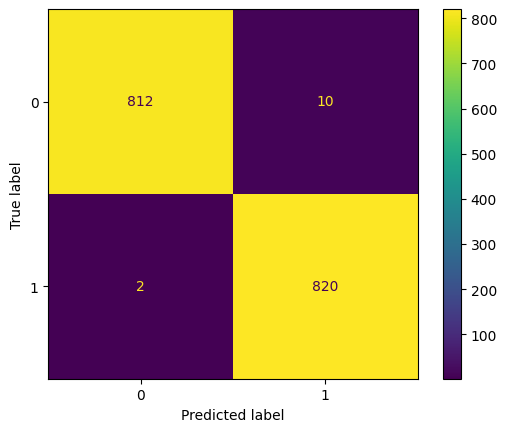

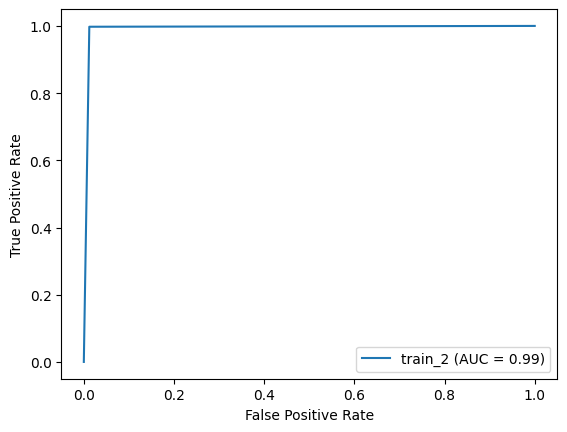

  0%|          | 0/6 [00:00<?, ?it/s]


----------------------------- Classification report for validation_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.934426
1,Recall,0.934066
2,Specificity,0.934783
3,Precision,0.934066
4,F1 Score,0.934066


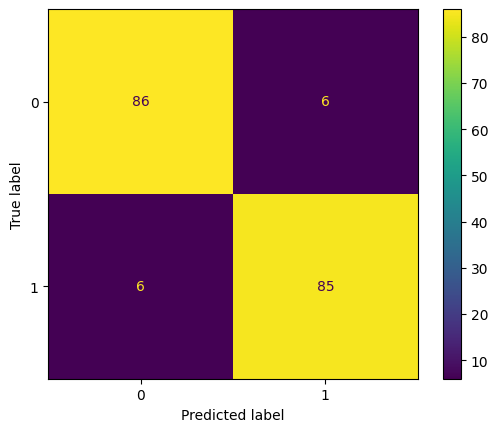

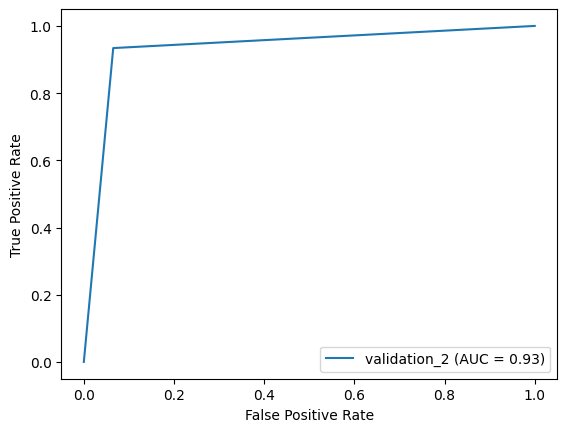

  0%|          | 0/15 [00:00<?, ?it/s]


----------------------------- Classification report for test_2 dataset -----------------------------



,Metric,Score
0,Accuracy,0.951860
1,Recall,0.938865
2,Specificity,0.964912
3,Precision,0.964126
4,F1 Score,0.951327


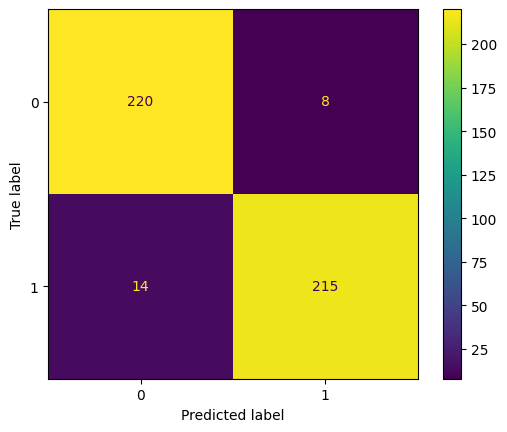

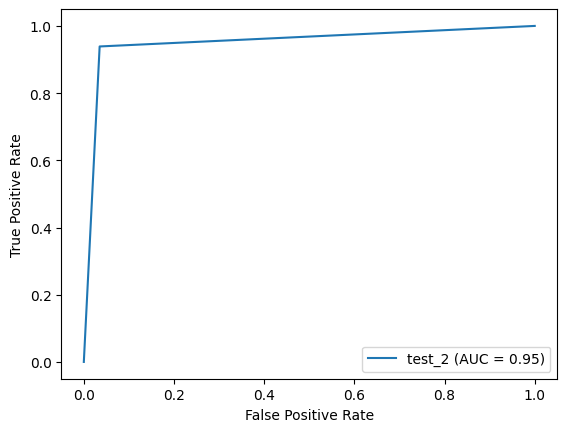

In [29]:
evaluate_on_all_datasets(model_2, datasets=DATASETS_2)

  0%|          | 0/112 [00:00<?, ?it/s]


----------------------------- Classification report for train_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.824256
1,Recall,0.855699
2,Specificity,0.792813
3,Precision,0.805071
4,F1 Score,0.829614


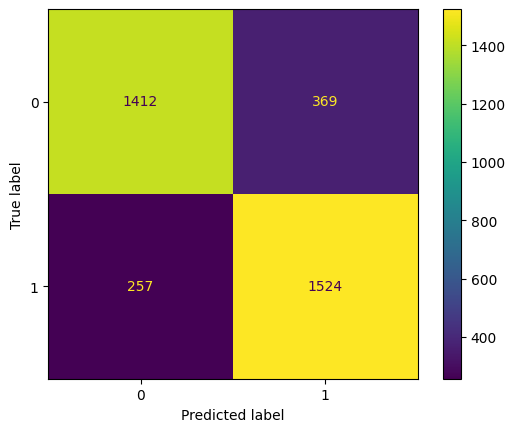

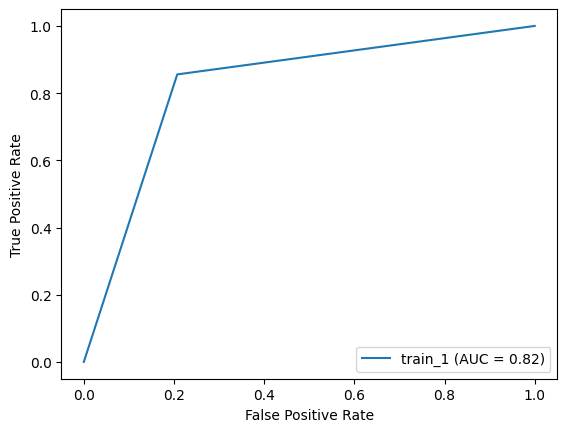

  0%|          | 0/13 [00:00<?, ?it/s]


----------------------------- Classification report for validation_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.830808
1,Recall,0.868687
2,Specificity,0.792929
3,Precision,0.807512
4,F1 Score,0.836983


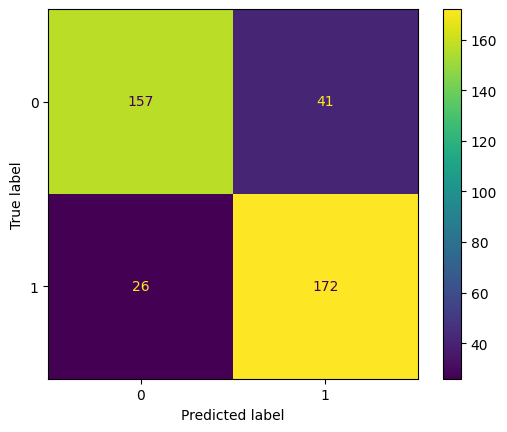

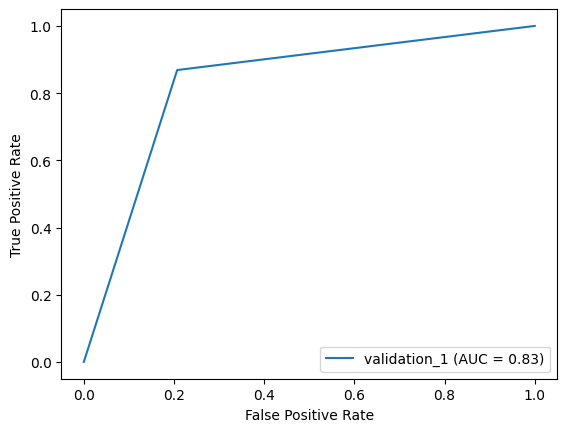

  0%|          | 0/31 [00:00<?, ?it/s]


----------------------------- Classification report for test_1 dataset -----------------------------



,Metric,Score
0,Accuracy,0.812121
1,Recall,0.822222
2,Specificity,0.802020
3,Precision,0.805941
4,F1 Score,0.814000


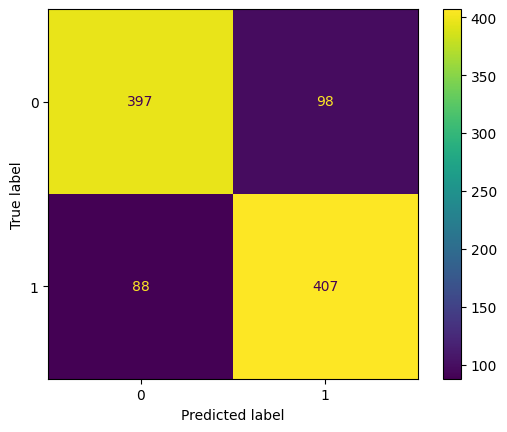

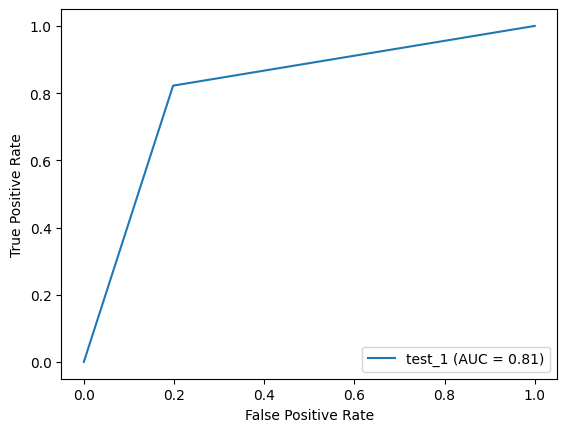

In [30]:
evaluate_on_all_datasets(model_2, datasets=DATASETS_1)